<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/Hierarchical_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 92.3 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from rasterio.mask import mask
import geopandas as gpd

In [ ]:
# Load RGB image
rgb = rasterio.open("/content/RGB.tif")

# Load habitat map (vector)
habitat = gpd.read_file("/content/Ballymore_habitat_map2018_ITM.shp")

In [ ]:
# Reproject habitat to match RGB CRS
habitat = habitat.to_crs(rgb.crs)

In [ ]:
out_image, out_transform = mask(rgb, habitat.geometry, crop=True)

In [ ]:
out_meta = rgb.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

In [ ]:
with rasterio.open("clipped_rgb.tif", "w", **out_meta) as dest:
    dest.write(out_image)

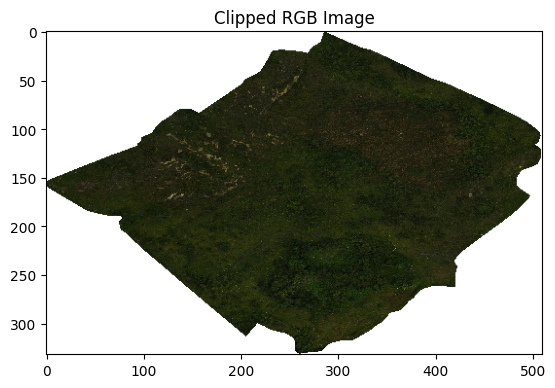

In [ ]:
import matplotlib.pyplot as plt

# Transpose the image data from (bands, height, width) to (height, width, bands) for matplotlib
img_display = out_image.transpose((1, 2, 0))

# Display the image
plt.imshow(img_display)
plt.title("Clipped RGB Image")
plt.show()

In [ ]:
with rasterio.open("/content/clipped_rgb.tif") as src:
    img = src.read()  # shape: (bands, rows, cols)
    profile = src.profile

# Reshape to (pixels, bands)
n_bands, rows, cols = img.shape
X = img.reshape(n_bands, rows * cols).T

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize

# Load habitat vector
habitat = gpd.read_file("/content/Ballymore_habitat_map2018_ITM.shp")
habitat = habitat.to_crs(profile["crs"])

# Load multispectral raster
with rasterio.open("clipped_rgb.tif") as src:
    profile = src.profile
    transform = src.transform
    shape = (src.height, src.width)

# Rasterize habitat polygons (using 'class_id' field from shapefile)
habitat_raster = rasterize(
    [(geom, value) for geom, value in zip(habitat.geometry, habitat["ClassID"])],
    out_shape=shape,
    transform=transform,
    fill=0,
    dtype="int32"
)


In [ ]:
print(habitat['FossittTyp'].unique())

['Transition mire and quaking bog' 'Rich fen and flush'
 'Rich fen and flush/Transition mire and quaking bog\r\nquaking bog'
 'Raised bog' 'Marsh' 'Scrub/Dry meadows and grassy verges'
 'Transition mire and quaking bog/Marsh' 'Scrub/Cutover bog']


In [ ]:
import numpy as np

with rasterio.open("clipped_rgb.tif") as src:
    img = src.read()  # shape: (bands, rows, cols)

n_bands, rows, cols = img.shape
X = img.reshape(n_bands, rows * cols).T
y = habitat_raster.flatten()

# Mask out no-data
mask = y > 0
X = X[mask]
y = y[mask]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Example: broad groups (adjust based on your habitat codes)
# Suppose classes 1–3 are vegetation, 4–5 are water, 6–7 are urban
broad_groups = np.where(np.isin(y, [1,2,3]), 1,
                np.where(np.isin(y, [4,5]), 2, 3))

# Step A: Broad classification
X_train, X_test, y_train, y_test = train_test_split(X, broad_groups, test_size=0.3, random_state=42)
rf_broad = RandomForestClassifier(n_estimators=200, random_state=42)
rf_broad.fit(X_train, y_train)
print("Broad-level classification report:")
print(classification_report(y_test, rf_broad.predict(X_test)))

# Step B: Fine classification within vegetation
veg_mask = broad_groups == 1
X_veg = X[veg_mask]
y_veg = y[veg_mask]

X_train, X_test, y_train, y_test = train_test_split(X_veg, y_veg, test_size=0.3, random_state=42)
rf_fine = RandomForestClassifier(n_estimators=200, random_state=42)
rf_fine.fit(X_train, y_train)
print("Vegetation subclass classification report:")
print(classification_report(y_test, rf_fine.predict(X_test)))



Broad-level classification report:
              precision    recall  f1-score   support

           1       0.47      0.51      0.49     11116
           2       0.44      0.49      0.46      9902
           3       0.40      0.30      0.34      7203

    accuracy                           0.45     28221
   macro avg       0.44      0.43      0.43     28221
weighted avg       0.44      0.45      0.44     28221

Vegetation subclass classification report:
              precision    recall  f1-score   support

           1       0.64      0.70      0.67      4640
           2       0.40      0.32      0.35      2170
           3       0.75      0.74      0.74      4287

    accuracy                           0.64     11097
   macro avg       0.59      0.59      0.59     11097
weighted avg       0.63      0.64      0.64     11097



In [ ]:
broad_pred = rf_broad.predict(X)
fine_pred = rf_fine.predict(X[broad_pred == 1])

final_pred = broad_pred.copy()
final_pred[broad_pred == 1] = fine_pred

classified_map = np.zeros(rows * cols, dtype=np.int32)
classified_map[mask] = final_pred
classified_map = classified_map.reshape(rows, cols)

# Save output
out_profile = profile.copy()
out_profile.update(dtype=rasterio.int32, count=1)

with rasterio.open("hierarchical_classification.tif", "w", **out_profile) as dst:
    dst.write(classified_map, 1)


In [ ]:
habitat_raster = rasterize(
    [(geom, value) for geom, value in zip(habitat.geometry, habitat["ClassID"])],
    out_shape=shape,
    transform=transform,
    fill=0,
    dtype="int32"
)

In [ ]:
# Flatten raster into 1D array of labels
y_labels = habitat_raster.flatten()

# Mask out no-data pixels
mask = y_labels > 0
X = X[mask]          # spectral features from your TIFF
y_labels = y_labels[mask]  # habitat labels aligned with pixels



IndexError: boolean index did not match indexed array along axis 0; size of axis is 94067 but size of corresponding boolean axis is 169320

In [ ]:
# Broad groups: Wetlands vs Scrub/Grassland
wetland_classes = [
    "Transition mire and quaking bog",
    "Rich fen and flush",
    "Raised bog",
    "Marsh",
    "Fen-Bog complex",
    "Bog-Marsh complex"
]
scrub_classes = [
    "Scrub-Meadow",
    "Scrub-Bog"
]

broad_groups = np.where(np.isin(y_labels, wetland_classes), 1, 2)


NameError: name 'y_labels' is not defined

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, broad_groups, test_size=0.3, random_state=42)

rf_broad = RandomForestClassifier(n_estimators=200, random_state=42)
rf_broad.fit(X_train, y_train)

print("Broad-level classification report:")
print(classification_report(y_test, rf_broad.predict(X_test)))


In [ ]:
# Wetlands fine classification
wet_mask = broad_groups == 1
X_wet = X[wet_mask]
y_wet = y_labels[wet_mask]  # original habitat labels

if len(X_wet) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X_wet, y_wet, test_size=0.3, random_state=42)
    rf_wet = RandomForestClassifier(n_estimators=200, random_state=42)
    rf_wet.fit(X_train, y_train)
    print("Wetland subclass classification report:")
    print(classification_report(y_test, rf_wet.predict(X_test)))

# Scrub/Grassland fine classification
scrub_mask = broad_groups == 2
X_scrub = X[scrub_mask]
y_scrub = y_labels[scrub_mask]

if len(X_scrub) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X_scrub, y_scrub, test_size=0.3, random_state=42)
    rf_scrub = RandomForestClassifier(n_estimators=200, random_state=42)
    rf_scrub.fit(X_train, y_train)
    print("Scrub subclass classification report:")
    print(classification_report(y_test, rf_scrub.predict(X_test)))


In [ ]:
# Predict broad groups
broad_pred = rf_broad.predict(X)

# Predict wetlands subclasses
wet_pred = rf_wet.predict(X[broad_pred == 1]) if len(X_wet) > 0 else []

# Predict scrub subclasses
scrub_pred = rf_scrub.predict(X[broad_pred == 2]) if len(X_scrub) > 0 else []

# Merge predictions back
final_pred = broad_pred.copy()
if len(wet_pred) > 0:
    final_pred[broad_pred == 1] = wet_pred
if len(scrub_pred) > 0:
    final_pred[broad_pred == 2] = scrub_pred

# Reshape to raster
classified_map = np.zeros(rows * cols, dtype=np.int32)
classified_map[mask] = final_pred
classified_map = classified_map.reshape(rows, cols)

# Save output
out_profile = profile.copy()
out_profile.update(dtype=rasterio.int32, count=1)

with rasterio.open("hierarchical_classification.tif", "w", **out_profile) as dst:
    dst.write(classified_map, 1)
